# Import Libraries and Set Up Environment

In [78]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil
import zipfile
from PIL import Image
import kagglehub
from IPython.display import Image as IPyImage, display

# Load and Explore the Dataset

Pada langkah ini, kita menggunakan **Food11 Image Dataset** yang diunduh dari Kaggle 
[sini](https://www.kaggle.com/datasets/trolukovich/food11-image-dataset).

Perbedaan utama antara dataset asli dengan versi yang digunakan di sini adalah: dataset telah disusun ulang dengan menempatkan setiap kategori makanan dalam folder terpisah. Struktur ini memudahkan proses pelatihan model menggunakan fungsi `image_dataset_from_directory()` dari TensorFlow.

## Ringkasan Dataset:
- **Jumlah Gambar:** 16.643
- **Jumlah Kelas:** 11
- **Ukuran Gambar:** Beragam dan akan diseragamkan selama preprocessing
- **Split Data:**
  - `training/`
  - `validation/`
  - `evaluation/`

Masing-masing split memuat 11 kategori makanan berikut:
1. Roti (Bread)  
2. Produk Susu (Dairy product)  
3. Makanan Penutup (Dessert)  
4. Telur (Egg)  
5. Makanan Goreng (Fried food)  
6. Daging (Meat)  
7. Mie atau Pasta (Noodles-Pasta)  
8. Nasi (Rice)  
9. Makanan Laut (Seafood)  
10. Sup (Soup)  
11. Sayur dan Buah (Vegetable-Fruit)


In [2]:
path = kagglehub.dataset_download("trolukovich/food11-image-dataset")
print("Path to dataset files:", path)

data_dir = path
train_dir = os.path.join(data_dir, "training")
val_dir = os.path.join(data_dir, "validation")
eval_dir = os.path.join(data_dir, "evaluation")

Path to dataset files: /kaggle/input/food11-image-dataset


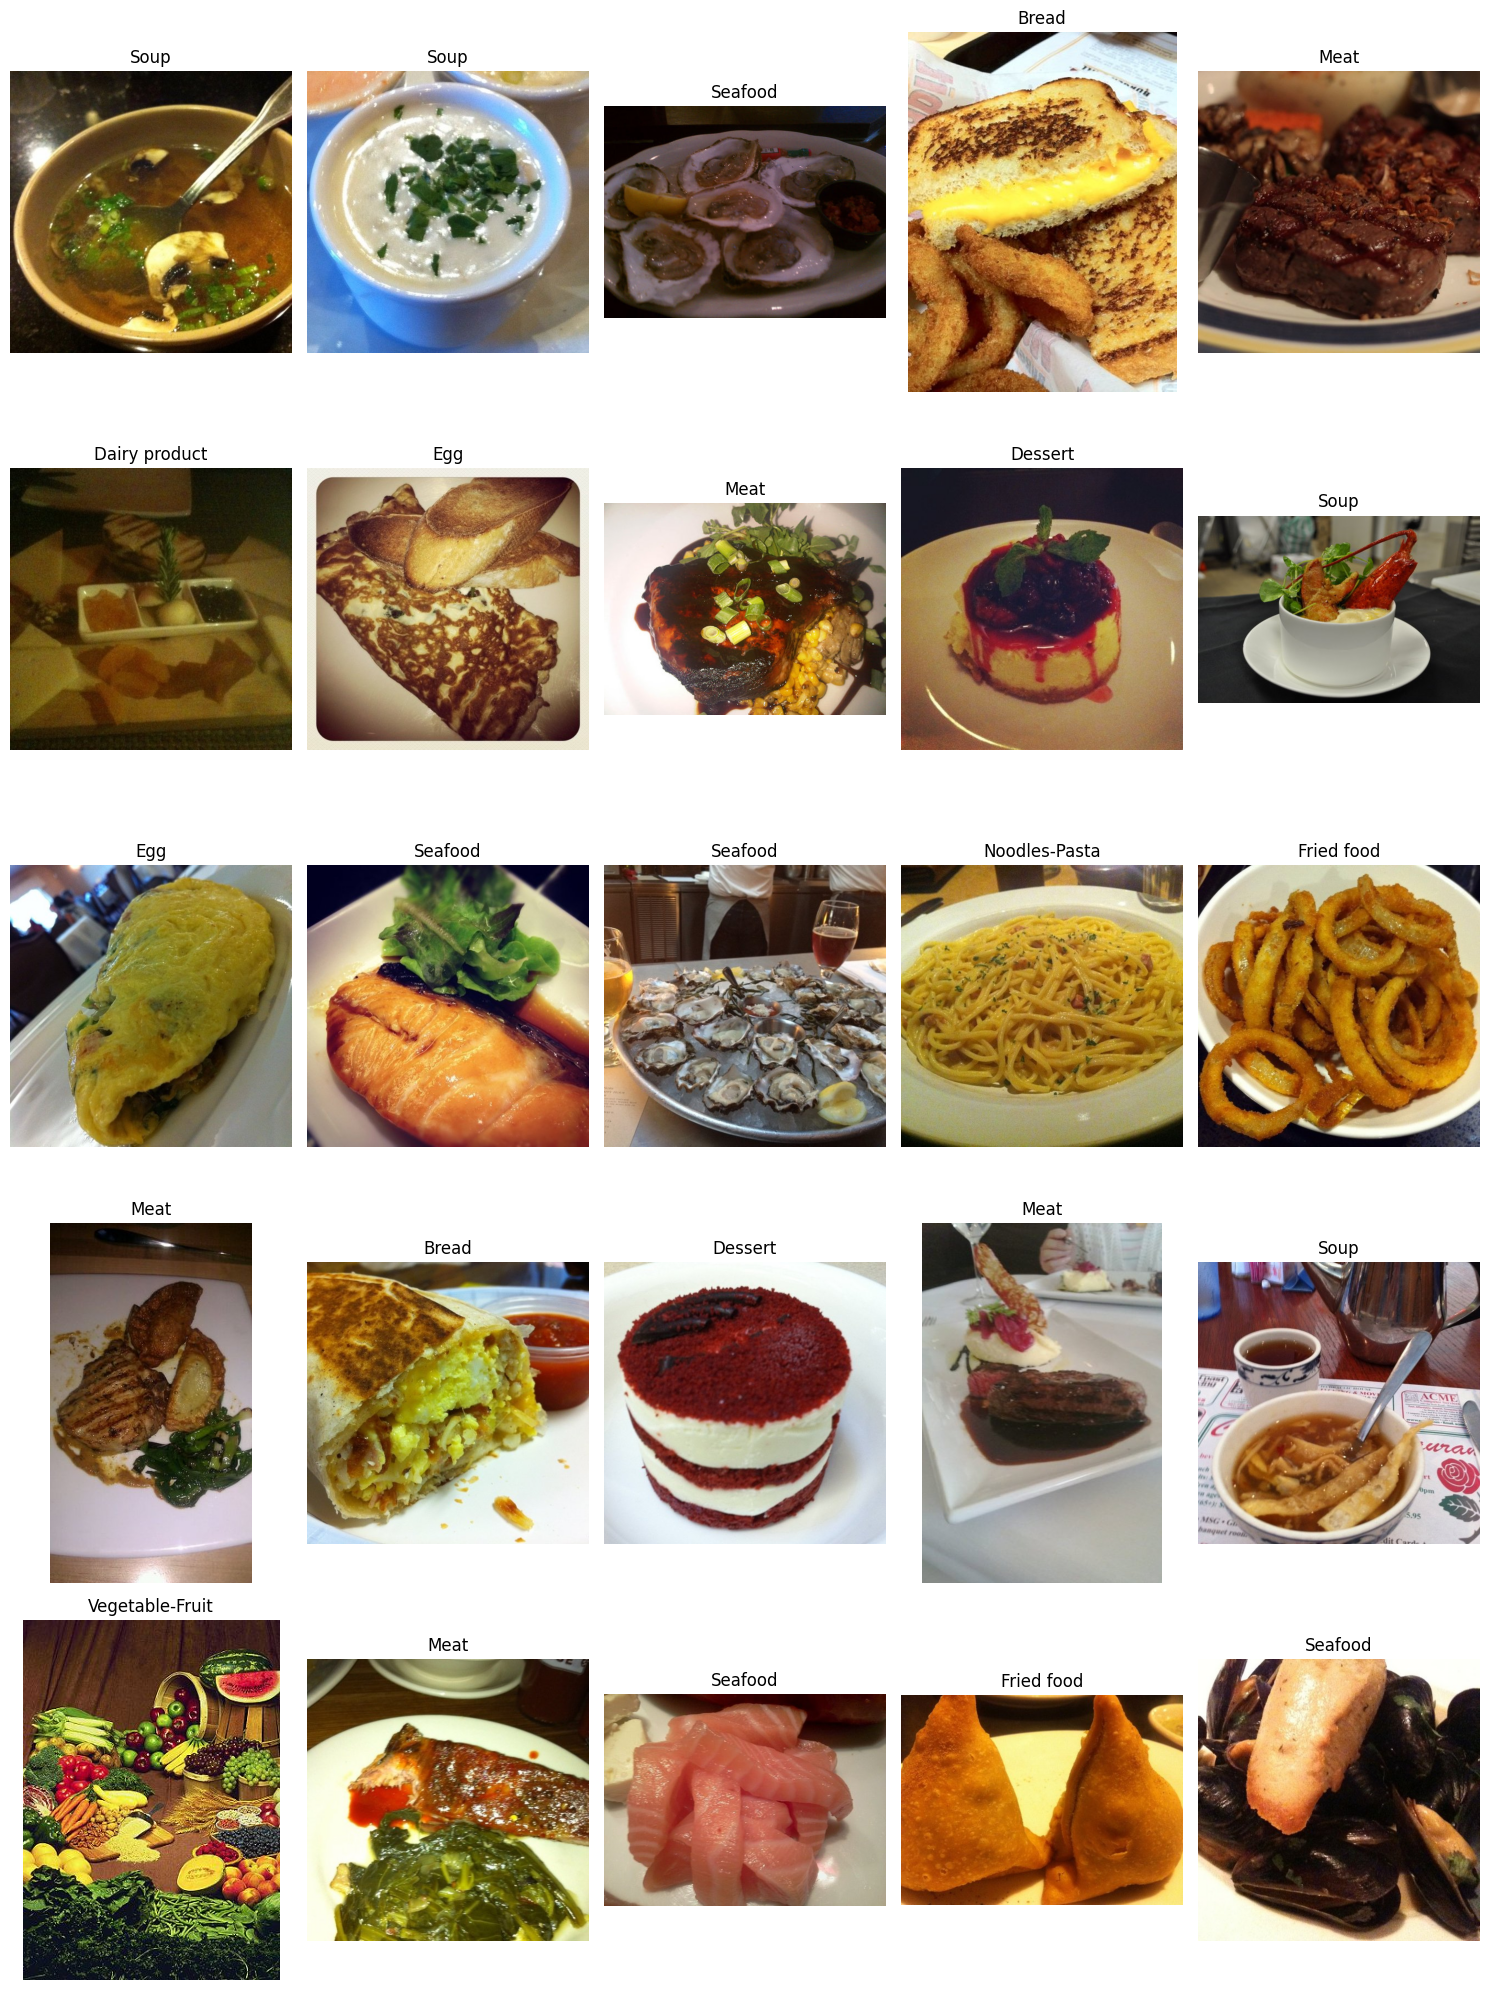

In [5]:
original_path = train_dir
class_folders = os.listdir(original_path)
all_image_paths = []
all_labels = []

for label in class_folders:
    folder_path = os.path.join(original_path, label)
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('jpg', 'jpeg', 'png')):
            all_image_paths.append(os.path.join(folder_path, fname))
            all_labels.append(label)
            
idxs = random.sample(range(len(all_image_paths)), 25)
plt.figure(figsize=(15, 20))
for i, idx in enumerate(idxs):
    img = Image.open(all_image_paths[idx])
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(all_labels[idx])
    plt.axis("off")
plt.tight_layout()
plt.show()

# Preprocess Images

1. **Resize Gambar**  
   Gambar diubah ukurannya menjadi 224x224 piksel agar sesuai dengan input model CNN. Ini dilakukan karena ukuran asli gambar bervariasi.

2. **Normalisasi**  
   Nilai piksel gambar yang awalnya 0–255 diubah menjadi 0–1 dengan cara membagi nilai piksel dengan 255. Tujuannya adalah untuk mempercepat dan menstabilkan proses pelatihan.

3. **Augmentasi (untuk data training)**  
   Untuk memperkaya data dan mencegah overfitting, gambar pelatihan dapat diubah secara acak, misalnya diputar, diperbesar, atau dicerminkan ke kanan-kiri. Teknik ini hanya diterapkan pada data training, bukan pada data validasi atau evaluasi.

4. **Konversi ke Dataset TensorFlow**  
   Gambar yang telah diproses dikelompokkan menjadi batch dan dijadikan dataset TensorFlow menggunakan `image_dataset_from_directory()`. Fungsi ini juga bisa diset untuk melakukan prefetch dan cache agar training lebih cepat.


In [6]:
IMG_SIZE = (384, 384)
BATCH_SIZE = 32

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=[0.8, 1.2],
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [10]:
train_dataset = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
valid_dataset = valid_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_dataset = test_datagen.flow_from_directory(eval_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


# Build Model 

In [15]:
base_model = EfficientNetV2L(include_top=False, weights='imagenet', input_shape=(384, 384, 3))
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = Sequential([
    base_model,
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.num_classes, activation='softmax')
])


In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)        │ (None, 12, 12, 1280)        │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │       1,474,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,586,859 (456.19 MB)

 Trainable params: 12,594,123 (48.04 MB)

 Non-trainable params: 106,992,736 (408.14 MB)

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=25, callbacks=[
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best.keras", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
])

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745449737.453869     158 service.cc:148] XLA service 0x7e107404c0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745449737.454734     158 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745449745.108896     158 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1745449763.552701     158 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745449763.900471     158 gpu_timer.cc:

 43/309 ━━━━━━━━━━━━━━━━━━━━ 6:11 1s/step - accuracy: 0.4748 - loss: 1.5912

E0000 00:00:1745449875.933651     157 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745449876.268986     157 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


309/309 ━━━━━━━━━━━━━━━━━━━━ 713s 2s/step - accuracy: 0.7197 - loss: 0.8971 - val_accuracy: 0.9061 - val_loss: 0.3762 - learning_rate: 0.0010
Epoch 2/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.8886 - loss: 0.3694 - val_accuracy: 0.9338 - val_loss: 0.2409 - learning_rate: 0.0010
Epoch 3/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.9138 - loss: 0.2782 - val_accuracy: 0.9475 - val_loss: 0.2147 - learning_rate: 0.0010
Epoch 4/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.9249 - loss: 0.2549 - val_accuracy: 0.9292 - val_loss: 0.2516 - learning_rate: 0.0010
Epoch 5/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.9312 - loss: 0.2168 - val_accuracy: 0.9501 - val_loss: 0.1857 - learning_rate: 0.0010
Epoch 6/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.9475 - loss: 0.1824 - val_accuracy: 0.9469 - val_loss: 0.1988 - learning_rate: 0.0010
Epoch 7/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.9503 - loss: 0.1735 - val_

# Evaluate Model Performance

In [20]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

105/105 ━━━━━━━━━━━━━━━━━━━━ 60s 575ms/step - accuracy: 0.9579 - loss: 0.1530
Test Accuracy: 96.62%


105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 396ms/step


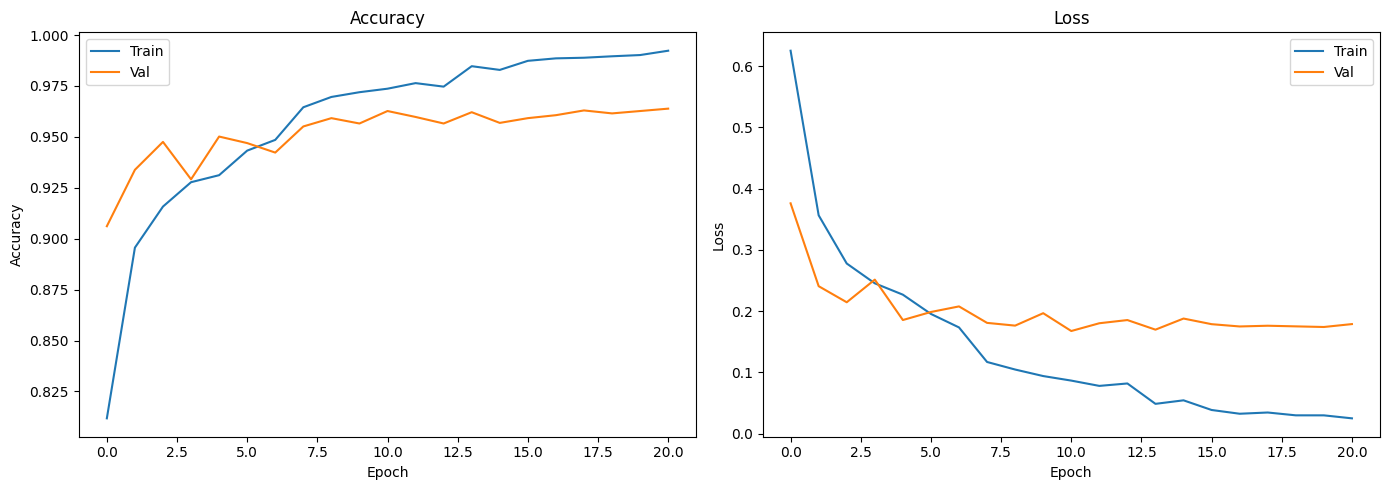

In [25]:
x_test = test_dataset
pred1 = model.predict(x_test)
final_pred = pred1
final_labels = np.argmax(final_pred, axis=1)
true_labels = test_dataset.classes

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the Model

In [21]:
model.export('saved_model')
print("Model disimpan dalam format TensorFlow SavedModel.")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name='keras_tensor_3096')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  138609219846992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138609219849296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138609219850064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138609219848336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138609219849104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138609219850256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138609219851216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138609219851984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138609219848528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138609219850640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1386092198521

In [58]:
if not os.path.exists("tflite"):
    os.makedirs("tflite")
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

W0000 00:00:1745462847.520344      83 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745462847.520381      83 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [59]:
import tensorflowjs as tfjs
if not os.path.exists("tfjs_model"):
    os.makedirs("tfjs_model")
tfjs.converters.save_keras_model(model, "tfjs_model")
print("Model disimpan dalam format TensorFlow.js.")

failed to lookup keras version from the file,
    this is likely a weight only file
Model disimpan dalam format TensorFlow.js.


In [61]:
os.makedirs("submission/tfjs_model", exist_ok=True)
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/saved_model", exist_ok=True)

shutil.copy("model.tflite", "submission/tflite/model.tflite")
shutil.copytree("saved_model/variables", "submission/saved_model/variables", dirs_exist_ok=True)
shutil.copy("saved_model/saved_model.pb", "submission/saved_model/saved_model.pb")
shutil.copytree("tfjs_model", "submission/tfjs_model", dirs_exist_ok=True)

shutil.make_archive("/kaggle/working/submission", 'zip', "submission")
print("Model telah disimpan dan dikompresi dalam format SavedModel, TFLite, dan TensorFlow.js.")

Model telah disimpan dan dikompresi dalam format SavedModel, TFLite, dan TensorFlow.js.


#  Inference on New Images ( TF Lite)

In [75]:
labels = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food',
          'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
os.makedirs("tflite", exist_ok=True)
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

In [76]:
with open("tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

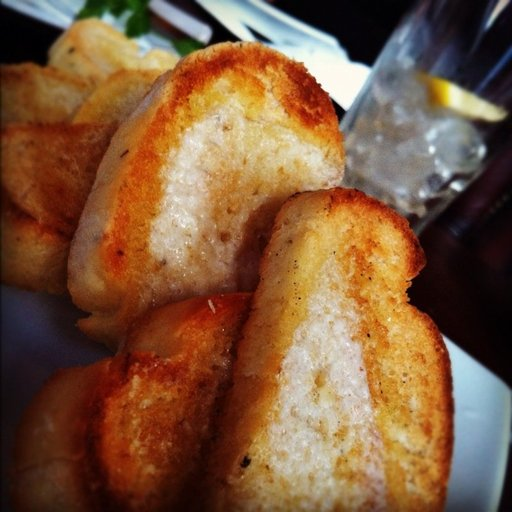

Predicted Index: 0
Predicted Label: Bread


In [80]:
def preprocess_image(image_path, target_size=(384, 384)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img, dtype=np.float32)
    img = preprocess_input(img)  
    img = np.expand_dims(img, axis=0)
    return img

# Ganti path ke gambar di folder roti-coba
image_path = "/kaggle/input/coba-tflite/roti.jpg"
input_data = preprocess_image(image_path)

# Load TFLite model dan lakukan inference
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Ambil label prediksi
predicted_index = np.argmax(output_data)
with open("tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]
predicted_label = labels[predicted_index]

# Tampilkan hasil
display(IPyImage(image_path))
print(f"Predicted Index: {predicted_index}")
print(f"Predicted Label: {predicted_label}")


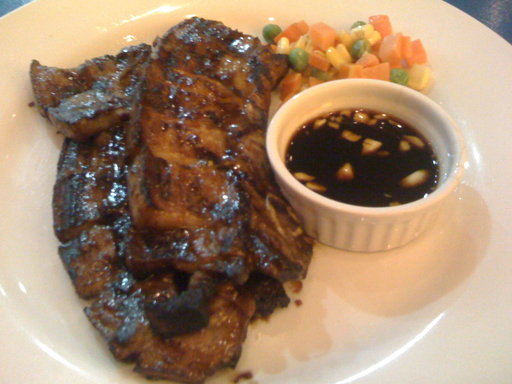

Predicted Index: 5
Predicted Label: Meat


In [81]:
def preprocess_image(image_path, target_size=(384, 384)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img, dtype=np.float32)
    img = preprocess_input(img)  
    img = np.expand_dims(img, axis=0)
    return img

# Ganti path ke gambar di folder roti-coba
image_path = "/kaggle/input/coba-tflite/daging.jpg"
input_data = preprocess_image(image_path)

# Load TFLite model dan lakukan inference
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Ambil label prediksi
predicted_index = np.argmax(output_data)
with open("tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]
predicted_label = labels[predicted_index]

# Tampilkan hasil
display(IPyImage(image_path))
print(f"Predicted Index: {predicted_index}")
print(f"Predicted Label: {predicted_label}")


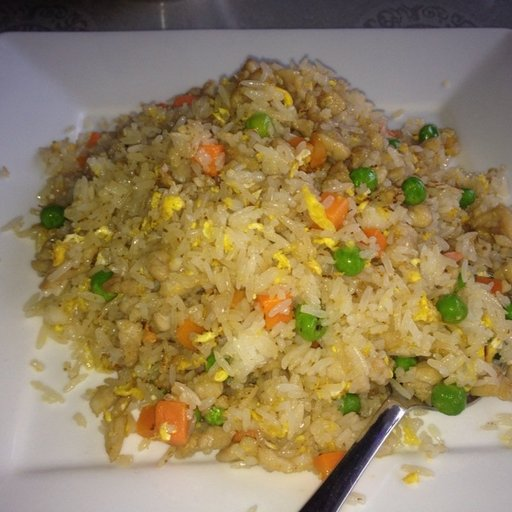

Predicted Index: 7
Predicted Label: Rice


In [82]:
def preprocess_image(image_path, target_size=(384, 384)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img, dtype=np.float32)
    img = preprocess_input(img)  
    img = np.expand_dims(img, axis=0)
    return img

# Ganti path ke gambar di folder roti-coba
image_path = "/kaggle/input/coba-tflite/nasi.jpeg"
input_data = preprocess_image(image_path)

# Load TFLite model dan lakukan inference
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Ambil label prediksi
predicted_index = np.argmax(output_data)
with open("tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]
predicted_label = labels[predicted_index]

# Tampilkan hasil
display(IPyImage(image_path))
print(f"Predicted Index: {predicted_index}")
print(f"Predicted Label: {predicted_label}")


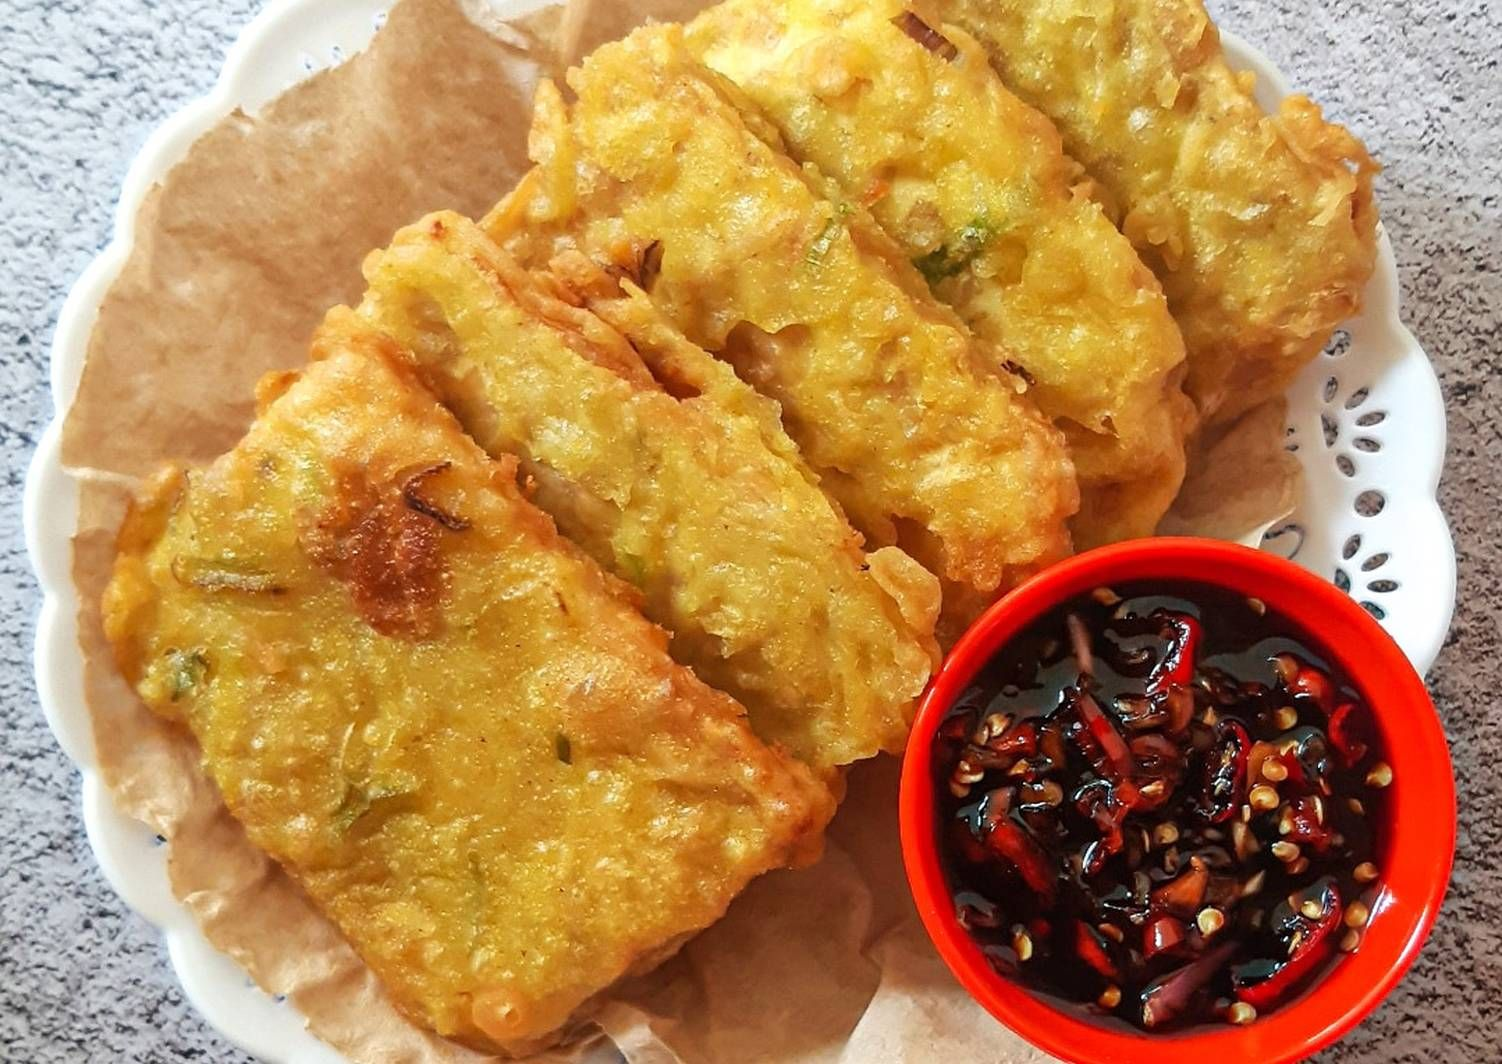

Predicted Index: 4
Predicted Label: Fried food


In [83]:
def preprocess_image(image_path, target_size=(384, 384)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img, dtype=np.float32)
    img = preprocess_input(img)  
    img = np.expand_dims(img, axis=0)
    return img

# Ganti path ke gambar di folder roti-coba
image_path = "/kaggle/input/coba-nn/gorengan.jpg"
input_data = preprocess_image(image_path)

# Load TFLite model dan lakukan inference
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Ambil label prediksi
predicted_index = np.argmax(output_data)
with open("tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]
predicted_label = labels[predicted_index]

# Tampilkan hasil
display(IPyImage(image_path))
print(f"Predicted Index: {predicted_index}")
print(f"Predicted Label: {predicted_label}")


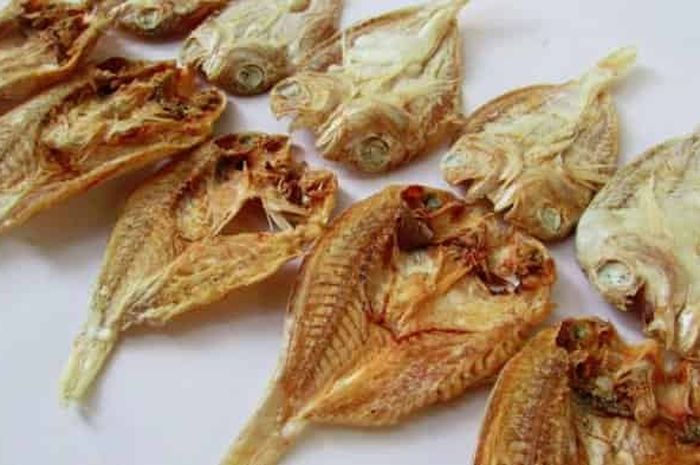

Predicted Index: 8
Predicted Label: Seafood


In [84]:
def preprocess_image(image_path, target_size=(384, 384)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img, dtype=np.float32)
    img = preprocess_input(img)  
    img = np.expand_dims(img, axis=0)
    return img

# Ganti path ke gambar di folder roti-coba
image_path = "/kaggle/input/coba-nn/ikan asin.jpg"
input_data = preprocess_image(image_path)

# Load TFLite model dan lakukan inference
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Ambil label prediksi
predicted_index = np.argmax(output_data)
with open("tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]
predicted_label = labels[predicted_index]

# Tampilkan hasil
display(IPyImage(image_path))
print(f"Predicted Index: {predicted_index}")
print(f"Predicted Label: {predicted_label}")


In [87]:
!pip list

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Package                            Version             Editable project location
---------------------------------- ------------------- -------------------------
absl-py                            1.4.0
accelerate                         1.3.0
aiofiles                           22.1.0
aiohappyeyeballs                   2.6.1
aiohttp                            3.11.16
aiosignal                          1.3.2
aiosqlite                          0.21.0
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.4
ale-py                             0.10.1
alembic                            1.15.2
altair                             5.5.0
annotated-types                    0.7.0
annoy                              1.17.3
ansicolors                         1.1.8
antlr4-python3-runti